<h1> Code Vulnerabilities Detection Using CodeBert </h1>



In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


## Overview<a name='toc'></a>
<ol>
<li><a href='#load'> Data Analysis and Preprocessing</a></li>
<li><a href='#bert'>СodeBert</a></li>
</ol>

In [2]:
from tqdm import tqdm, trange
import multiprocessing

from transformers import (WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup,
                          RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
from datasets import Dataset
from transformers import RobertaTokenizer, RobertaForMaskedLM, pipeline
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

import torch

!pip install evaluate
import evaluate
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.5 MB/s eta 0:00:00


### 1. Data Loading and Preparation
Dataset<a name='load'></a>

[SARD](https://www.kaggle.com/datasets/cerengen/securec-c-source-code-for-vulnerabilty-detection/)

The Software Assurance Reference Dataset (SARD) is a growing collection of test programs with documented vulnerabilities in the code. Test examples range from small synthetic programs to large applications. The programs are written in C, C++, Java, PHP, and C# and cover more than 150 classes of vulnerabilities.

A collection of more than 450,000 examples of vulnerabilities;
Covers over 150 classes of Common Weakness Enumeration (CWE)

In [3]:
pd.set_option('max_colwidth', 400)
df = pd.read_csv('multi_sard_all_data_marked.csv')

df.head()

code  \
0  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
1  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
2  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
3  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
4  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   

  CWE-Type DataType  
0   CWE114     SARD  
1   CWE114     SARD  
2   CWE114     SARD  
3   CWE114     SARD  
4   CWE114     SARD


CWE stands for Common Weakness Enumeration, which is a standardized list of software vulnerabilities or weaknesses. It is commonly used in the fields of cybersecurity and software engineering to categorize and describe security flaws in software and systems.
CWE stands for Common Weakness Enumeration, which is a standardized list of software vulnerabilities or weaknesses. It is commonly used in the fields of cybersecurity and software engineering to categorize and describe security flaws in software and systems.
exemple :CWE-79: Cross-Site Scripting (XSS)
CWE-89: SQL Injection
CWE-200: Information Exposure

In [4]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 52802
Types of CWE: 109


In [5]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [6]:
df['label']=df['CWE-Type'].map(label2id)
df.head()

code  \
0  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
1  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
2  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
3  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
4  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   

  CWE-Type DataType  label  
0   CWE114     SARD      0  
1   CWE114     SARD      0  
2   CWE114     SARD      0  
3   CWE114     SARD      0  
4   CWE114     SARD      0

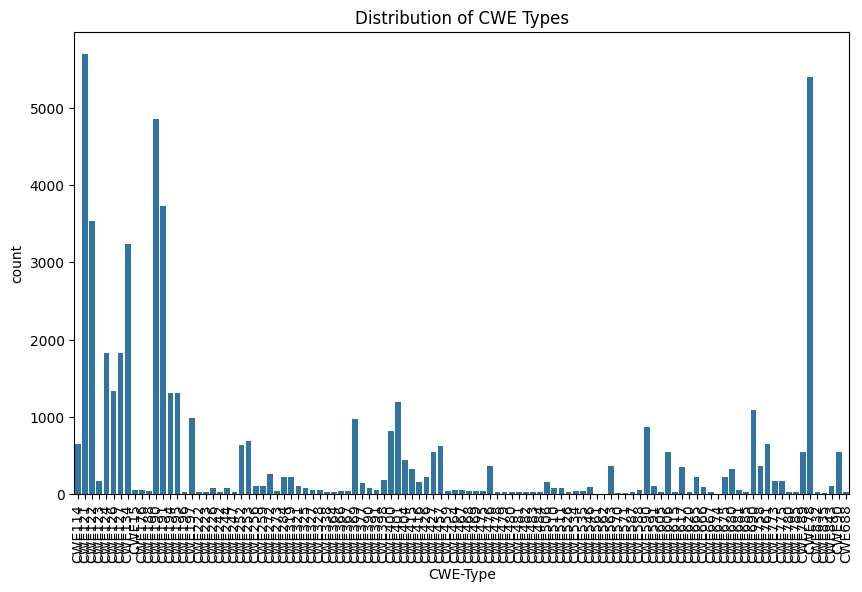

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

**Split the dataset into training and holdout samples**



In [8]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)


 ### 2. BERT (Bidirectional Encoder Representations from Transformers), spécifiquement la version pré-entraînée bert-base-uncased de la bibliothèque transformers de Hugging Face. <a name='bert'></a>

In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True)

tokenized_datasets = ds.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/38016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4225 [00:00<?, ? examples/s]

In [11]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label2id))

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=7128, training_loss=0.6450902155352762, metrics={'train_runtime': 11356.5174, 'train_samples_per_second': 10.043, 'train_steps_per_second': 0.628, 'total_flos': 3.003611793968333e+16, 'train_loss': 0.6450902155352762, 'epoch': 3.0})

In [13]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.23581083118915558, 'eval_runtime': 123.0866, 'eval_samples_per_second': 34.325, 'eval_steps_per_second': 2.153, 'epoch': 3.0}



### 2. CodeBert <a name='bert'></a>

To load the data, we will use the Datasets library.

Datasets is a library for easy access to datasets and their collaborative use for audio, computer vision, and natural language processing (NLP) tasks.

It allows for the loading of datasets and the use of built-in data processing methods to prepare datasets for use in training neural network models. The library supports the Apache Arrow format and processes large datasets without any memory constraints for optimal speed and efficiency. Also, the library is integrated with the Hugging Face Hub, which makes it easy to load a dataset and share it with the community.



**Tokenize the input sequences with program text using the trained tokenizer Codebert-base-mlm**

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/38016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4225 [00:00<?, ? examples/s]

**Data Collator**

Data Collators are objects that will form batches (data portions) using a list of dataset elements as input. These elements are of the same type as the elements in train_dataset or eval_dataset.

To be able to create batches, data collators can apply some processing (such as padding).

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

**Evaluate**
Data Collators are objects that will form batches (data portions) using a list of dataset elements as input. These elements are of the same type as the elements in train_dataset or eval_dataset.

To be able to create batches, data collators can apply some processing (such as padding).

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

[CodeBert](https://github.com/microsoft/CodeBERT)

A pre-trained model taken from a research paper by Microsoft's research division. This model was trained using the CodeSearchNet dataset, but instead of generating comments, it was used to train the model on a RoBERTa-based representation of code and natural language that is easy to understand.

In [ ]:
unique = len(df['CWE-Type'].unique())
unique

109

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=109, id2label=id2label, label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The Trainer class provides a full-featured PyTorch training API for most standard use cases.

Before creating a Trainer instance, it is necessary to create training arguments to access all customization points during training.

The API supports distributed training on multiple GPUs, mixed precision using NVIDIA Apex, and a native accelerator for PyTorch.

Trainer contains the basic training loop that supports the aforementioned features. To implement custom functions, the following methods can be overridden:

- get_train_dataloader — Creates the training DataLoader.
- get_eval_dataloader — Creates the evaluation DataLoader.
- get_test_dataloader — Creates the test DataLoader.
- log — Logs information on the various objects watching training.
- create_optimizer_and_scheduler — Sets up the optimizer and learning rate scheduler if they were not passed at - init. Note, that you can also subclass or override the create_optimizer and create_scheduler methods separately.
- create_optimizer — Sets up the optimizer if it wasn’t passed at init.
- create_scheduler — Sets up the learning rate scheduler if it wasn’t passed at init.
- compute_loss - Computes the loss on a batch of training inputs.
- training_step — Performs a training step.
- prediction_step — Performs an evaluation/test step.
- evaluate — Runs an evaluation loop and returns metrics.
- predict — Returns predictions (with metrics if labels are available) on a test set.

In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-16-fe085bb64380>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=2376, training_loss=1.2646141244907572, metrics={'train_runtime': 3672.6458, 'train_samples_per_second': 10.351, 'train_steps_per_second': 0.647, 'total_flos': 1.0012039313227776e+16, 'train_loss': 1.2646141244907572, 'epoch': 1.0})


### 3.Graph CodeBert <a name='bert'></a>





In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np

In [ ]:
# Charger le tokenizer et le modèle (exemple avec GraphCodeBERT)
model_name = "microsoft/graphcodebert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenizer le dataset
tokenized_dataset = ds.map(preprocess_function, batched=True)

# Ajouter le padding automatique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Charger le modèle pour la classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

# Définir la métrique
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs"
)

# Entraîner le modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/539 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Map:   0%|          | 0/38016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4225 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/graphcodebert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-d8790b4bd9f4>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


TrainOutput(global_step=2376, training_loss=1.1045126031946253, metrics={'train_runtime': 4089.1737, 'train_samples_per_second': 9.297, 'train_steps_per_second': 0.581, 'total_flos': 1.0012039313227776e+16, 'train_loss': 1.1045126031946253, 'epoch': 1.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE114       0.98      1.00      0.99       131
      CWE121       0.84      0.96      0.90      1154
      CWE122       0.99      0.83      0.91       734
      CWE123       1.00      1.00      1.00        30
      CWE124       0.72      0.70      0.71       351
      CWE126       0.90      0.82      0.86       255
      CWE127       0.83      0.67      0.75       376
      CWE134       1.00      1.00      1.00       649
       CWE15       0.82      1.00      0.90         9
      CWE176       0.00      0.00      0.00        10
      CWE188       1.00      0.33      0.50         9
      CWE190       0.83      0.98      0.90       970
      CWE191       0.96      0.83      0.89       739
      CWE194       0.95      1.00      0.97       245
      CWE195       0.63      0.98      0.77       259
      CWE196       0.00      0.00      0.00         3
      CWE197       0.94      0.71      0.81       194
      CWE222       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


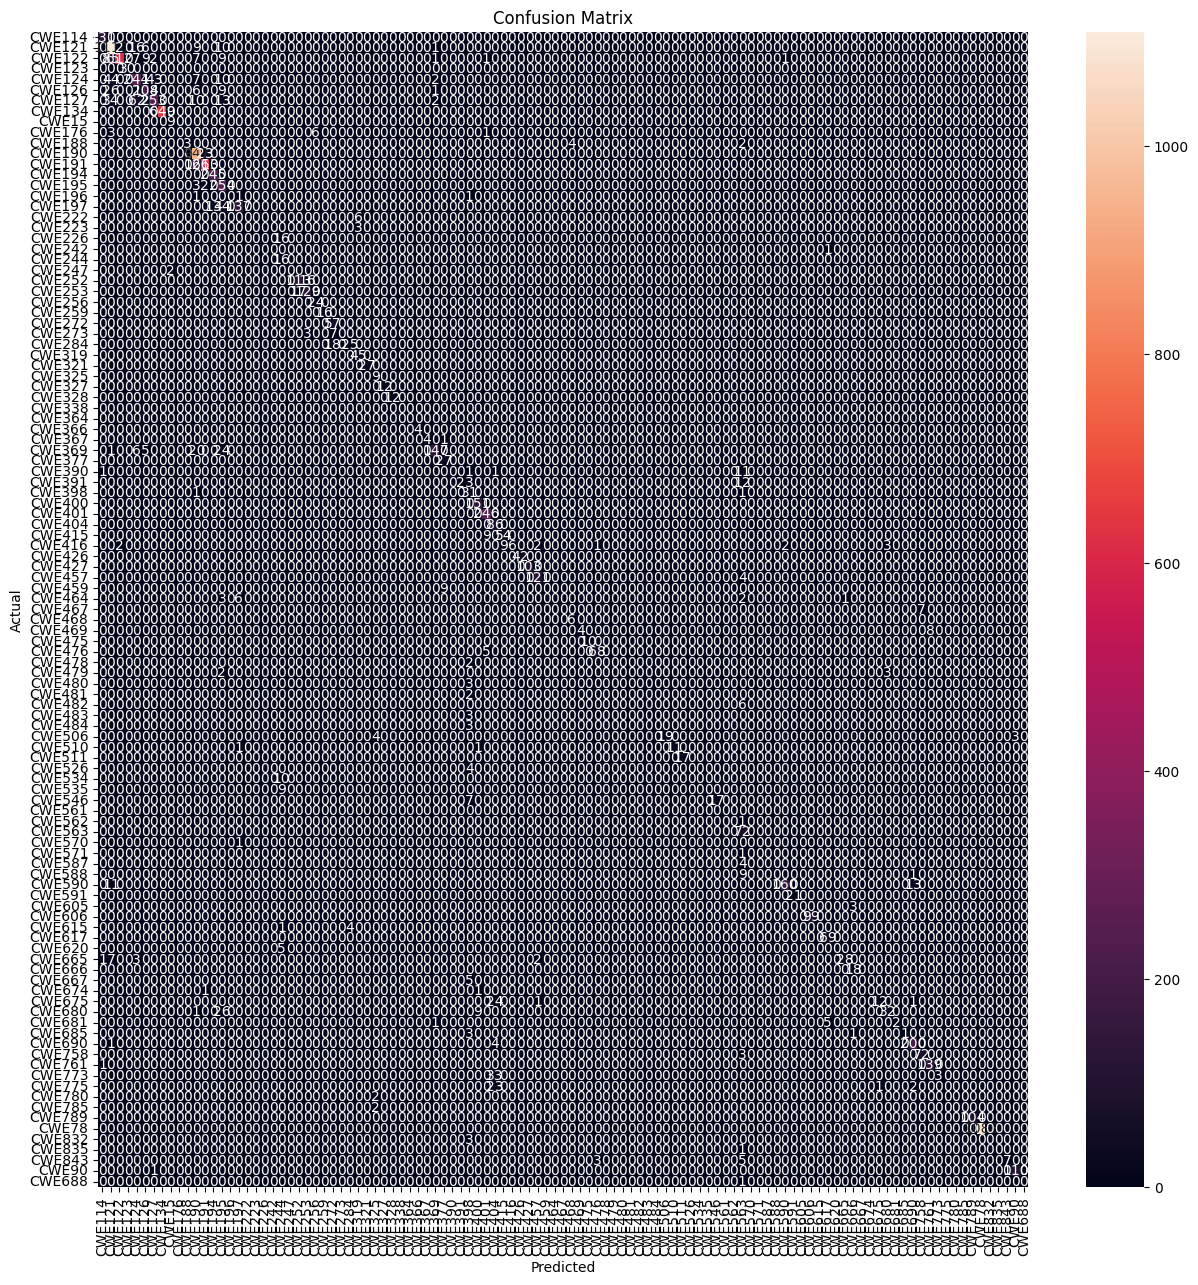

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
#code T5base
# Charger le tokenizer et le modèle (exemple avec GraphCodeBERT)
model_name = "Salesforce/codet5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

# Tokenizer le dataset
tokenized_dataset = ds.map(preprocess_function, batched=True)

# Ajouter le padding automatique
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Charger le modèle pour la classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id
)

# Définir la métrique
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Paramètres d'entraînement
training_args = TrainingArguments(
    output_dir="./trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_dir="./logs"
)

# Entraîner le modèle
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

Map:   0%|          | 0/38016 [00:00<?, ? examples/s]

Map:   0%|          | 0/4225 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/892M [00:00<?, ?B/s]

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at Salesforce/codet5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-12-04f32f8fc855>:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacity of 14.75 GiB of which 119.06 MiB is free. Process 3698 has 14.63 GiB memory in use. Of the allocated memory 14.33 GiB is allocated by PyTorch, and 177.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

### Testing a Trained Model

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE114       0.99      1.00      1.00       131
      CWE121       0.82      0.94      0.88      1154
      CWE122       0.93      0.86      0.89       734
      CWE123       1.00      1.00      1.00        30
      CWE124       0.71      0.76      0.73       351
      CWE126       0.98      0.81      0.89       255
      CWE127       0.88      0.60      0.71       376
      CWE134       1.00      1.00      1.00       649
       CWE15       0.00      0.00      0.00         9
      CWE176       1.00      0.70      0.82        10
      CWE188       1.00      0.22      0.36         9
      CWE190       0.95      0.87      0.91       970
      CWE191       0.81      0.97      0.88       739
      CWE194       0.95      1.00      0.97       245
      CWE195       0.73      0.97      0.83       259
      CWE196       0.00      0.00      0.00         3
      CWE197       1.00      0.71      0.83       194
      CWE222       0.00    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


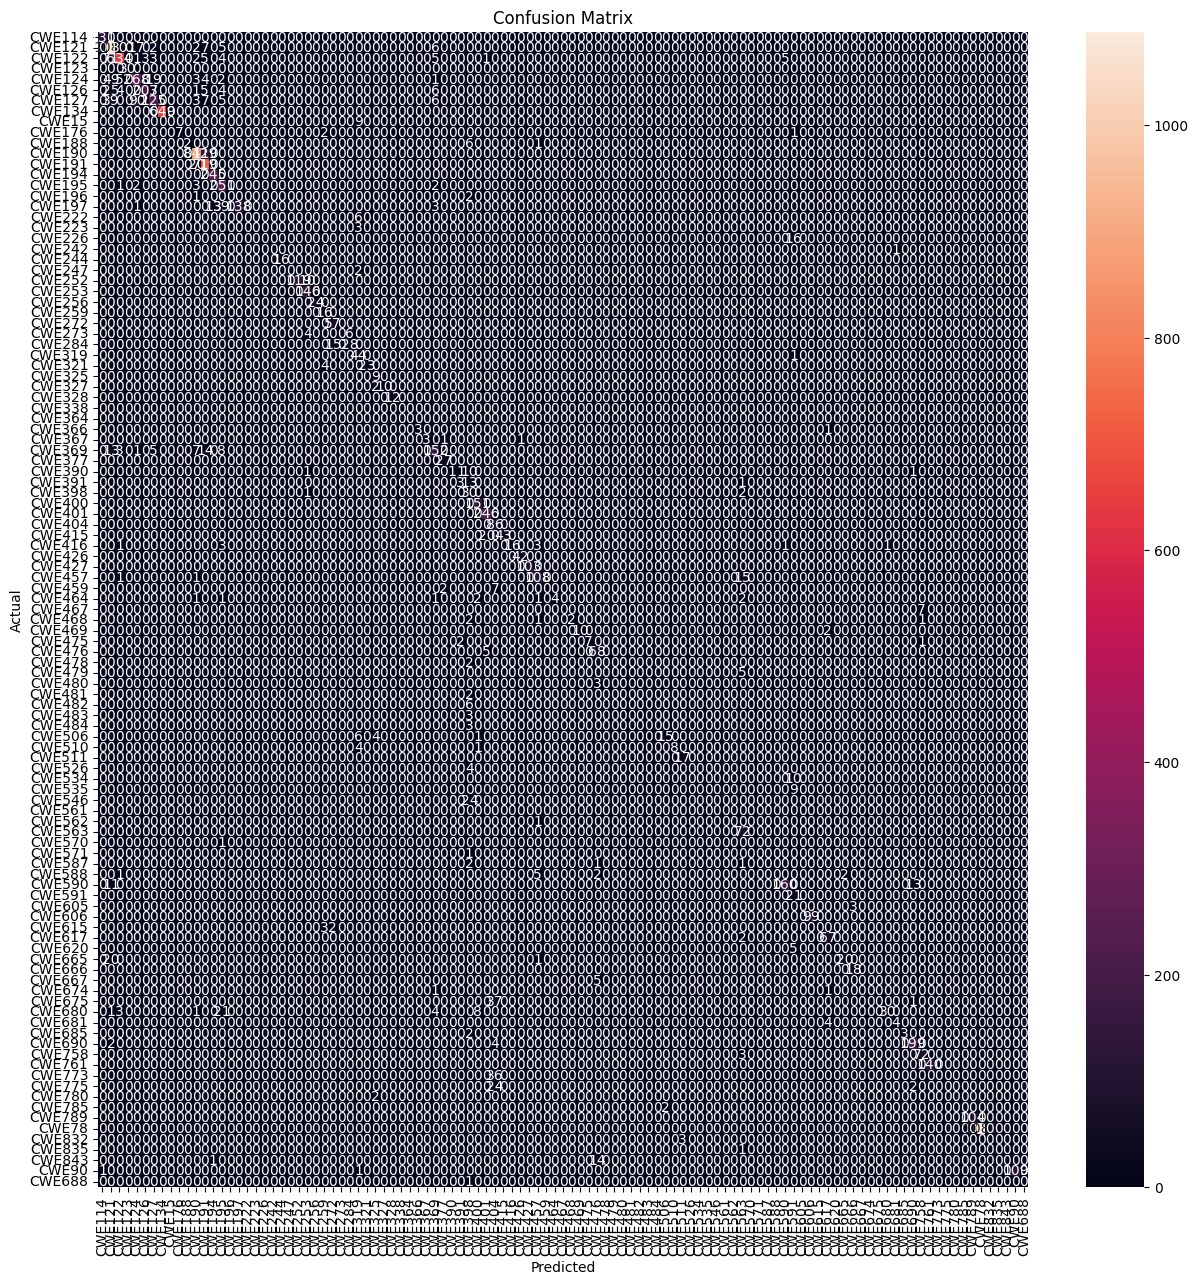

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
ls

marked_sard_and_vdisc_validate.csv       multi_sard_all_data_notmarked.csv      trained_model/
marked_sard_vdisc_train.csv              notmarked_sard_and_vdisc_validate.csv  wandb/
multi_sard_all_data_marked.csv           notmarked_sard_vdisc_train.csv
multi_sard_all_data_marked_filtered.csv  sample_data/


In [ ]:
!zip wandb wandb

  adding: wandb/ (stored 0%)


In [ ]:
!zip trained_model trained_model

  adding: trained_model/ (stored 0%)


In [ ]:
!zip -r file.zip /

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
	zip warning: name not matched: /proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/39/usr/share/icons/Humanity/mimes/48/application-vnd.rn-realmedia.svg
	zip warning: name not matched: /proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/self/task/40994/fd/3/proc/sel

In [ ]:
pd.set_option('max_colwidth', 400)
df = pd.read_csv('multi_sard_all_data_marked.csv')
df.head()

code  \
0  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
1  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
2  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
3  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   
4  \n \n \n #include "IncludeMarker"\n \n #include <IncludeMarker>\n \n #ifdef _WIN32\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #pragma comment(lib, "ws2_32") \n #define DefineMarker closesocket\n #else \n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #include <IncludeMarker>\n #define DefineMar...   

  CWE-Type DataType  
0   CWE114     SARD  
1   CWE114     SARD  
2   CWE114     SARD  
3   CWE114     SARD  
4   CWE114     SARD

In [ ]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 52802
Types of CWE: 109


In [ ]:
# Remove "CWE" from the CWE-Type column and convert to integers
df['CWE-Type'] = df['CWE-Type'].str.replace('CWE', '').astype(int)

# Filter the dataset
filtered_df = df[(df['CWE-Type'].isin([121, 122, 123, 124, 476])) | (df['CWE-Type'].between(780, 790))]

# Print the filtered DataFrame
print(filtered_df)


                                                                                                                                                                                                                                                                                                                                                                                                                  code  \
648    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct 

In [ ]:
# Convert CWE-Type back to string and add "CWE" prefix
filtered_df['CWE-Type'] = 'CWE' + filtered_df['CWE-Type'].astype(str)

# Print the filtered DataFrame
print(filtered_df)

                                                                                                                                                                                                                                                                                                                                                                                                                  code  \
648    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649    \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct 

<ipython-input-28-cc7ba0f42c98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['CWE-Type'] = 'CWE' + filtered_df['CWE-Type'].astype(str)


In [ ]:
df=filtered_df

In [ ]:
df.head()

code  \
648  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...   
650  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...   
651  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n \n static const int intMarker = 1; \n static const int intMarker = 0; \n \n #ifndef OMITBAD\n ...   
652  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n \n static int intMarker = 1; \n static int intMarker = 0; \n \n #ifndef OMITBAD\n \n \n #endif...   

    CWE-Type DataType  
648   CWE121     SARD  
649   CWE121     SARD  
650   CWE121     SARD  
651   CWE121     SARD  
652   CWE121     SARD

In [ ]:
df.to_csv('multi_sard_all_data_marked_filtered.csv')

In [ ]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 12156
Types of CWE: 8


In [ ]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [ ]:
df['label']=df['CWE-Type'].map(label2id)
df.head()

code  \
648  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n #endif \n \n \n \n #ifdef INC...   
649  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...   
650  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n #ifndef OMITBAD\n \n \n #endif \n \n #ifndef OMITGOOD\n \n \n \n \n \n \n #endif \n \n \n \n #...   
651  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n \n static const int intMarker = 1; \n static const int intMarker = 0; \n \n #ifndef OMITBAD\n ...   
652  \n \n \n #include "IncludeMarker"\n \n #ifndef _WIN32\n #include <IncludeMarker>\n #endif\n \n \n #define DefineMarker "0123456789abcdef0123456789abcde"\n \n typedef struct _charVoid\n {\n     char charMarkerArray[16];\n     void * voidPointerMarker;\n     void * voidPointerMarker;\n } charVoid;\n \n \n static int intMarker = 1; \n static int intMarker = 0; \n \n #ifndef OMITBAD\n \n \n #endif...   

    CWE-Type DataType  label  
648   CWE121     SARD      0  
649   CWE121     SARD      0  
650   CWE121     SARD      0  
651   CWE121     SARD      0  
652   CWE121     SARD      0

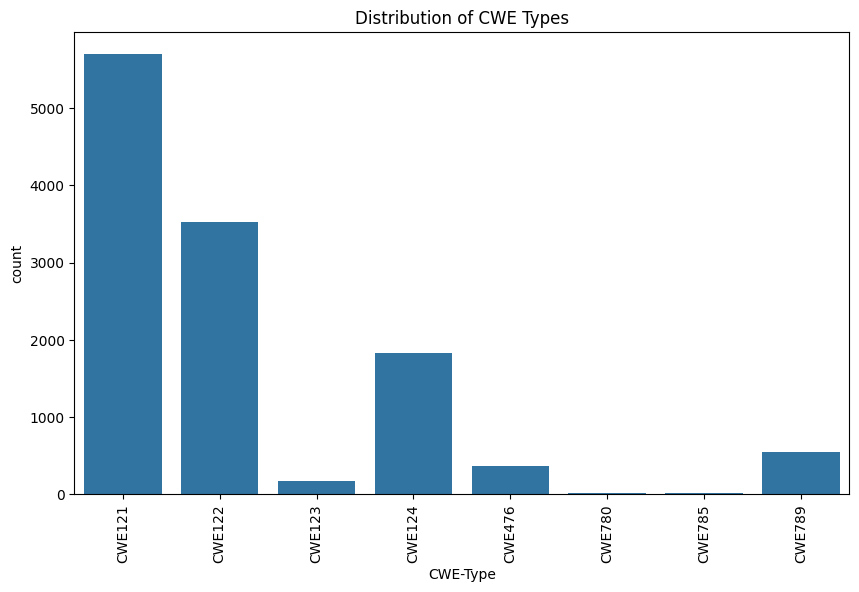

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

Map:   0%|          | 0/8751 [00:00<?, ? examples/s]

Map:   0%|          | 0/973 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=8, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-43-fe085bb64380>:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


TrainOutput(global_step=547, training_loss=0.5715119503097953, metrics={'train_runtime': 1023.4615, 'train_samples_per_second': 8.55, 'train_steps_per_second': 0.534, 'total_flos': 2302608883949568.0, 'train_loss': 0.5715119503097953, 'epoch': 1.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.90      0.94      0.92      1172
      CWE122       0.96      0.87      0.92       694
      CWE123       0.84      0.96      0.90        28
      CWE124       0.83      0.90      0.86       372
      CWE476       0.98      0.89      0.93        53
      CWE780       0.00      0.00      0.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       0.99      1.00      1.00       105

    accuracy                           0.91      2432
   macro avg       0.69      0.69      0.69      2432
weighted avg       0.91      0.91      0.91      2432



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


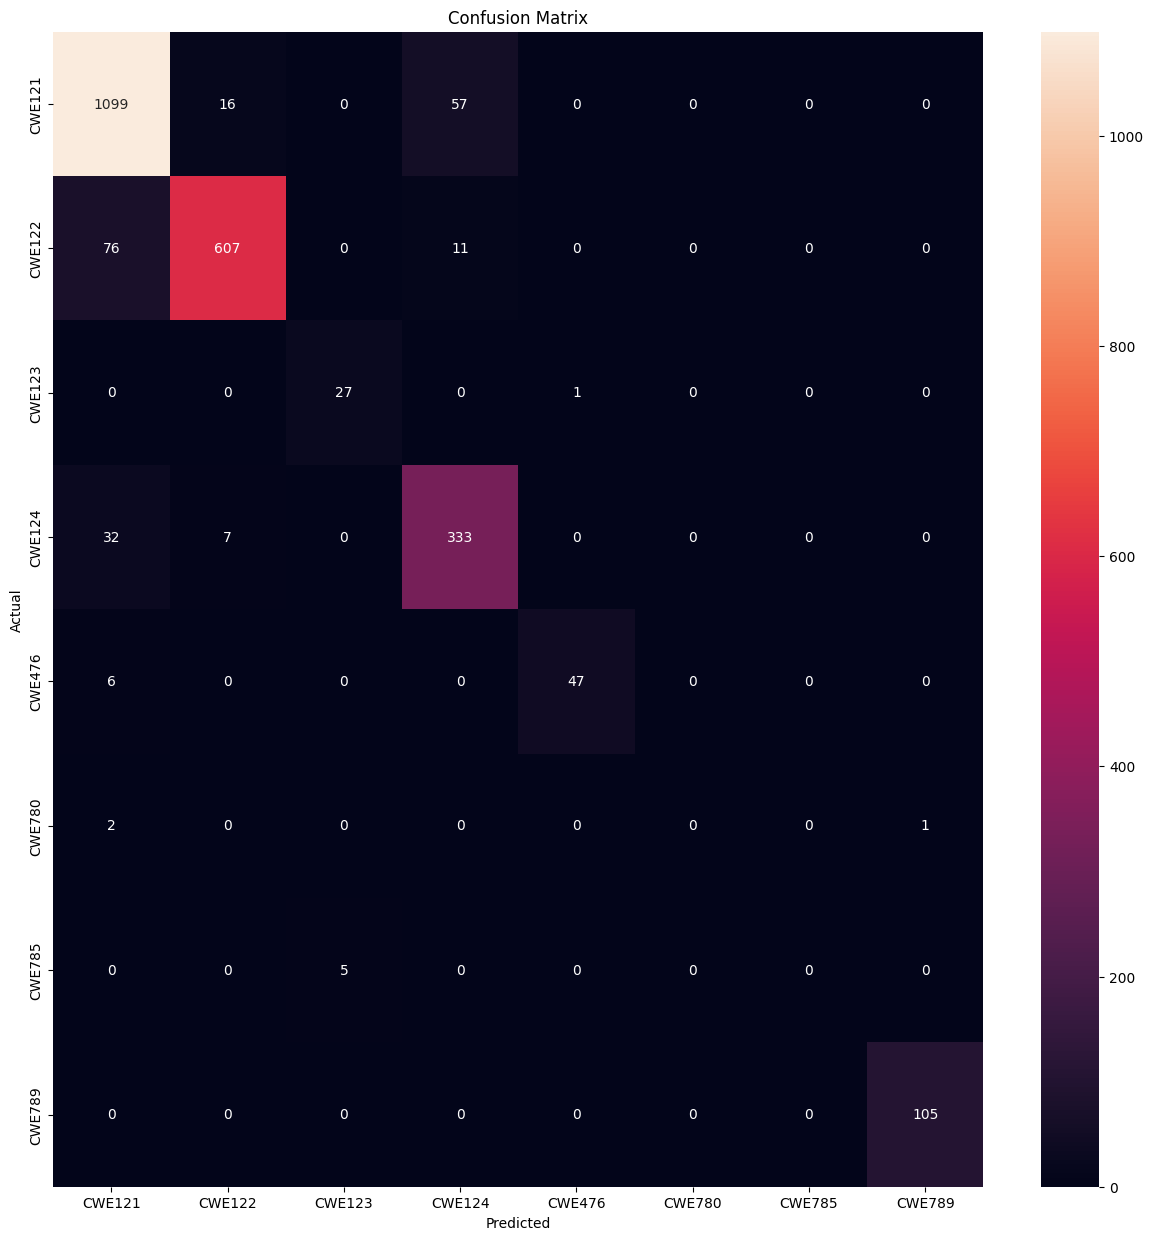

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

TRYING OTHER COMBINATIONS


In [ ]:
from transformers import BertTokenizer, BertForMaskedLM

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenized_dataset = ds.map(preprocess_function, batched=True)

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-uncased', num_labels=8, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=547, training_loss=0.5835624830814341, metrics={'train_runtime': 491.887, 'train_samples_per_second': 17.791, 'train_steps_per_second': 1.112, 'total_flos': 2302608883949568.0, 'train_loss': 0.5835624830814341, 'epoch': 1.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.88      0.94      0.91      1172
      CWE122       0.94      0.89      0.91       694
      CWE123       1.00      1.00      1.00        28
      CWE124       0.85      0.77      0.81       372
      CWE476       0.94      0.87      0.90        53
      CWE780       0.00      0.00      0.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       1.00      1.00      1.00       105

    accuracy                           0.90      2432
   macro avg       0.70      0.68      0.69      2432
weighted avg       0.90      0.90      0.90      2432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


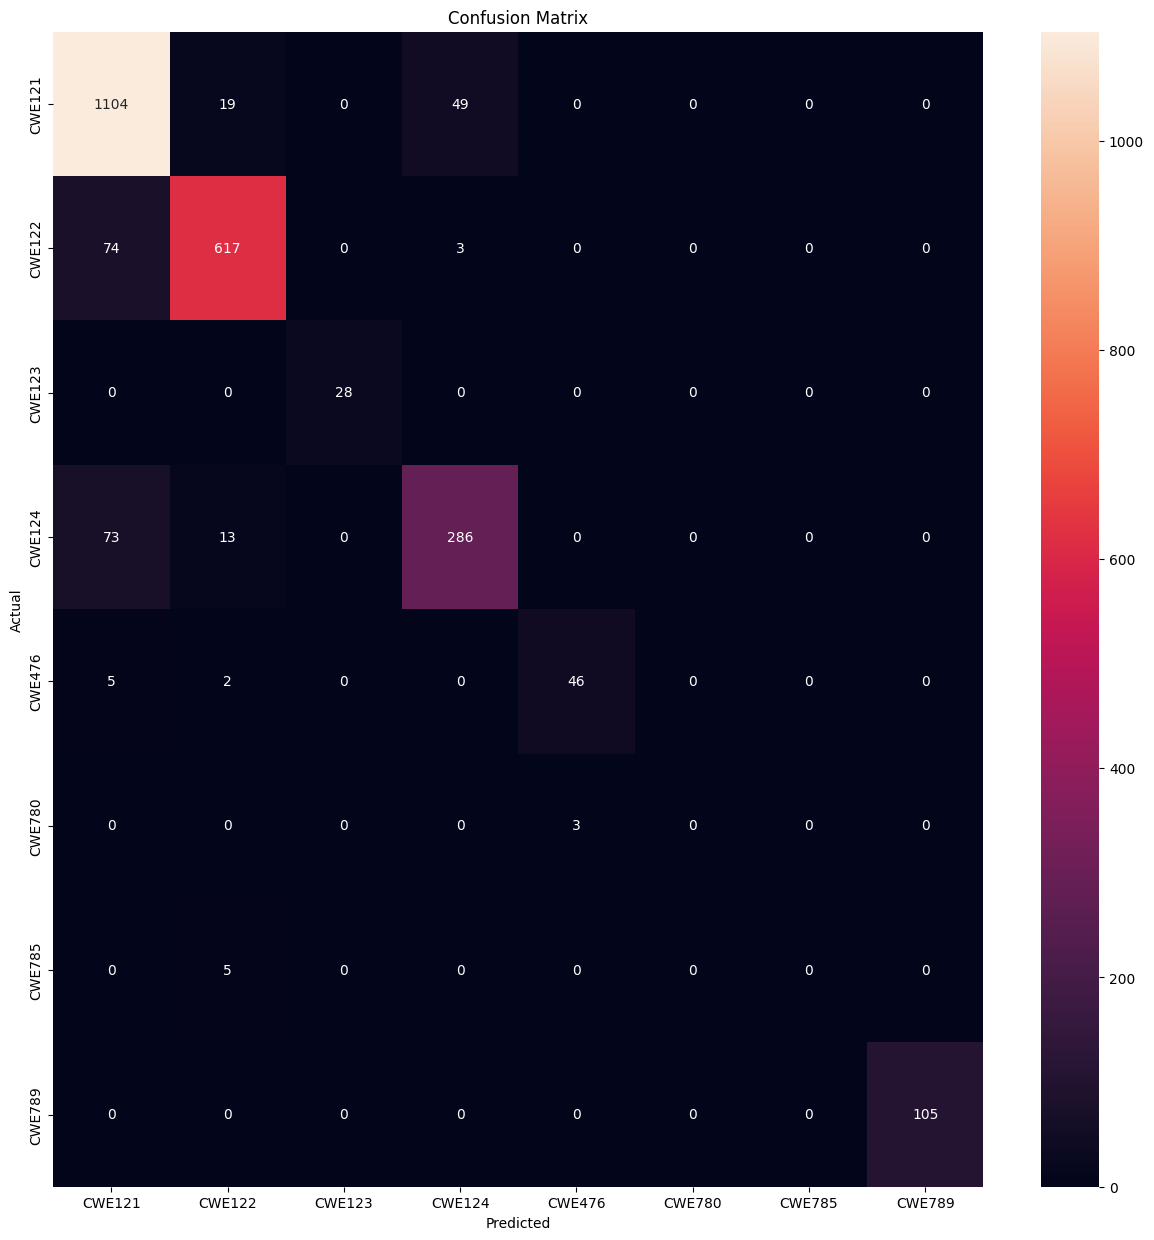

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
tokenized_dataset = ds.map(preprocess_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy = evaluate.load("accuracy")
model = AutoModelForSequenceClassification.from_pretrained(
    'distilbert-base-uncased', num_labels=8, id2label=id2label, label2id=label2id
)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=547, training_loss=0.6636258339751138, metrics={'train_runtime': 255.3876, 'train_samples_per_second': 34.266, 'train_steps_per_second': 2.142, 'total_flos': 1159346244132864.0, 'train_loss': 0.6636258339751138, 'epoch': 1.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

      CWE121       0.87      0.94      0.91      1172
      CWE122       0.98      0.88      0.92       694
      CWE123       1.00      1.00      1.00        28
      CWE124       0.81      0.80      0.81       372
      CWE476       0.93      0.77      0.85        53
      CWE780       0.00      0.00      0.00         3
      CWE785       0.00      0.00      0.00         5
      CWE789       1.00      1.00      1.00       105

    accuracy                           0.90      2432
   macro avg       0.70      0.67      0.69      2432
weighted avg       0.90      0.90      0.90      2432



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


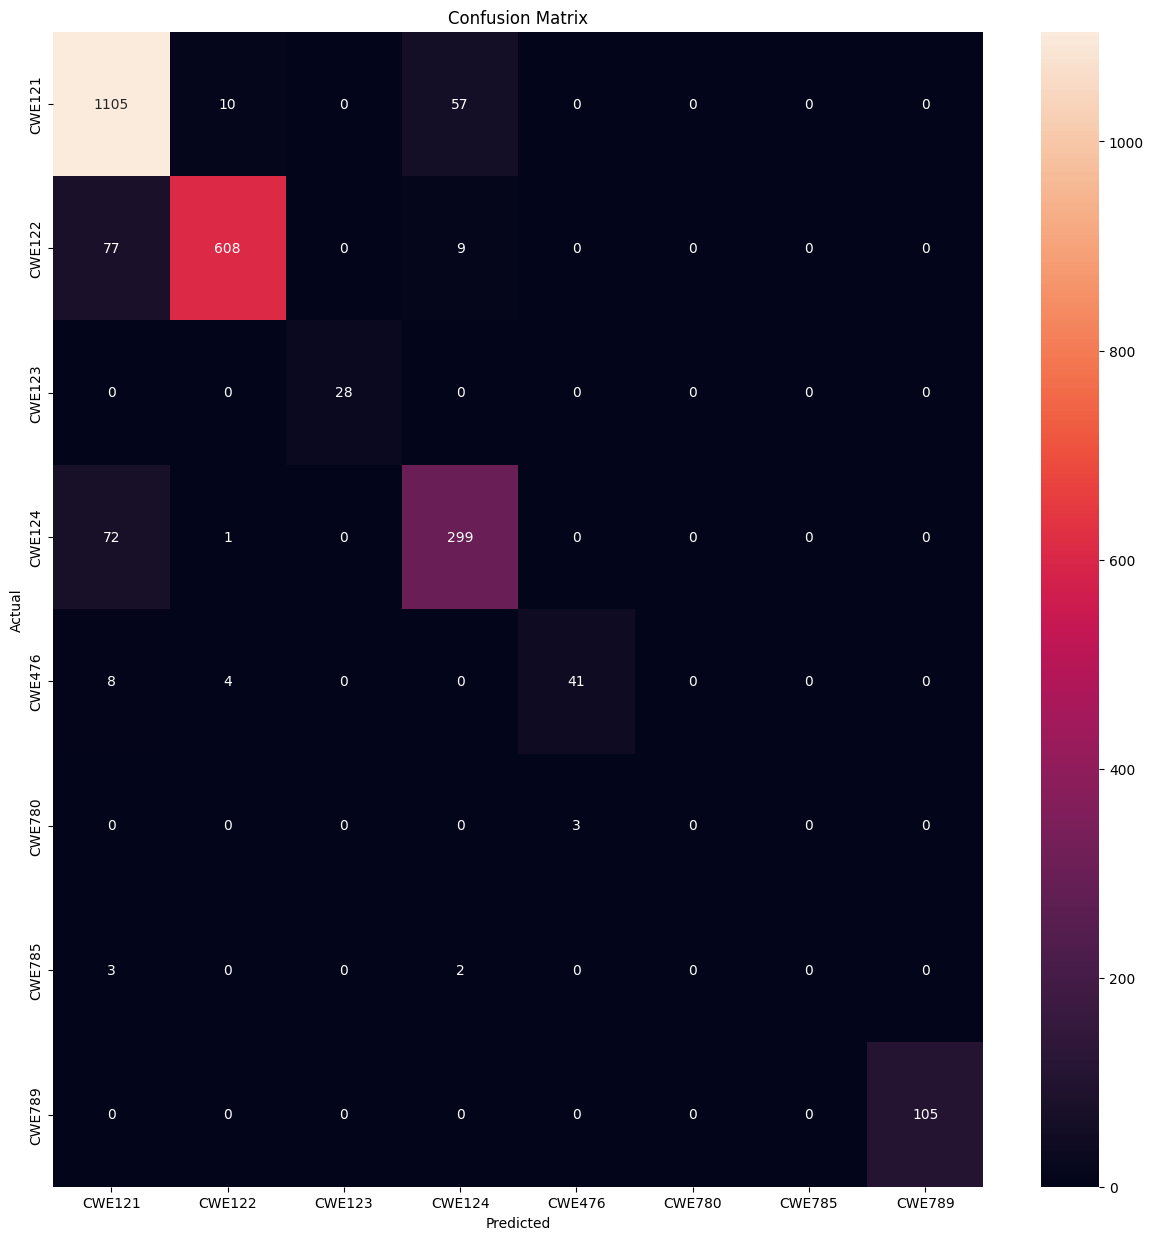

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

CODET5

In [ ]:
def extract_cwe_number(cwe_type):
    return cwe_type[3:]  # Extract the digits after "CWE"

df['CWE-Type'] = df['CWE-Type'].apply(extract_cwe_number)

In [ ]:
# Split dataset into training and validation sets
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)  # Adjust test_size as needed

In [ ]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForSeq2Seq

tokenizer = AutoTokenizer.from_pretrained('Salesforce/codet5-base')
model = AutoModelForSeq2SeqLM.from_pretrained('Salesforce/codet5-base')

def prepare_data(example):
    # Combine code and CWE label for seq2seq training
    input_text = example["code"]
    target_text = example["CWE-Type"]
    return tokenizer(input_text, target_text, truncation=True, padding=True)

train_dataset = df_train.apply(prepare_data, axis=1)
val_dataset = df_val.apply(prepare_data, axis=1)

In [ ]:
data_collator = DataCollatorForSeq2Seq(model=model, tokenizer=tokenizer)


In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    # ... other arguments
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


KeyError: 15780

In [ ]:
def classify_code(code_snippet):
   inputs = tokenizer(code_snippet, return_tensors="pt")
   output = model.generate(**inputs)
   predicted_label = tokenizer.decode(output[0], skip_special_tokens=True)
   return predicted_label

DIVERSEVUL

In [ ]:
import json

def load_json_lines(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data.append(json.loads(line.strip()))
            except json.JSONDecodeError as e:
                print(f"Error decoding line: {e}")
    return data

data = load_json_lines('/kaggle/input/llm-code-vulnerability/diversevul_20230702.json')

KeyboardInterrupt: 

In [ ]:
def create_csv(data, output_file):
    rows = []
    for item in data:
        func = item.get('func')
        cwe = item.get('cwe', [])  # Handle potential missing 'cwe'
        target = item.get('target')

        # Convert CWE list into a string
        cwe_str = ",".join(cwe)

        rows.append({'func': func, 'cwe': cwe_str, 'target': target})

    df = pd.DataFrame(rows)
    df.to_csv(output_file, index=False)

create_csv(data, 'processed_data_diversevul.csv')

In [ ]:
df=pd.read_csv('/kaggle/input/llm-code-vulnerability/processed_data_diversevul.csv')

In [ ]:
df.head()

code  \
0  int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t  opaque * compress_data,\n\t\t\t\t  int compress_size,\n\t\t\t\t  gnutls_datum_t ciphertext, uint8 type)\n{\n    uint8 MAC[MAX_HASH_SIZE];\n    uint16 c_length;\n    uint8 pad;\n    int length;\n    mac_hd_t td;\n    uint16 blocksize;\n    int ret, i, pad_failed = 0;\n    uint8 major, minor;\n    gnutls_protocol_t ver;\n    ...   
1  static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, ":memory:", sizeof(":memory:")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...   
2  unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...   
3  static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n    int sx, sy;\n    int dx, dy;\n    int width, height;\n    int depth;\n    int notify = 0;\n\n    depth = s->get_bpp((VGAState *)s) / 8;\n    s->get_resolution((VGAState *)s, &width, &height);\n\n    /* extra x, y */\n    sx = (src % (width * depth)) / depth;\n    sy = (src / (width * depth));\n    dx = (dst %...   
4  glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n                             uint8_t *dst,const uint8_t *src,\n                             int dstpitch,int srcpitch,\n                             int bltwidth,int bltheight)\n{\n    int x,y;\n    dstpitch -= bltwidth;\n    srcpitch -= bltwidth;\n    for (y = 0; y < bltheight; y++) {\n        for (x = 0; x < bltwidth; x++) {\n       ...   

  CWE-Type  target  
0     CWE0     1.0  
1   CWE264     1.0  
2     CWE0     1.0  
3   CWE787     1.0  
4   CWE787     1.0

In [ ]:
df=df.drop('target',axis=1)

In [ ]:
df.head()

code  \
0  int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t  opaque * compress_data,\n\t\t\t\t  int compress_size,\n\t\t\t\t  gnutls_datum_t ciphertext, uint8 type)\n{\n    uint8 MAC[MAX_HASH_SIZE];\n    uint16 c_length;\n    uint8 pad;\n    int length;\n    mac_hd_t td;\n    uint16 blocksize;\n    int ret, i, pad_failed = 0;\n    uint8 major, minor;\n    gnutls_protocol_t ver;\n    ...   
1  static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, ":memory:", sizeof(":memory:")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...   
2  unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...   
3  static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n    int sx, sy;\n    int dx, dy;\n    int width, height;\n    int depth;\n    int notify = 0;\n\n    depth = s->get_bpp((VGAState *)s) / 8;\n    s->get_resolution((VGAState *)s, &width, &height);\n\n    /* extra x, y */\n    sx = (src % (width * depth)) / depth;\n    sy = (src / (width * depth));\n    dx = (dst %...   
4  glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n                             uint8_t *dst,const uint8_t *src,\n                             int dstpitch,int srcpitch,\n                             int bltwidth,int bltheight)\n{\n    int x,y;\n    dstpitch -= bltwidth;\n    srcpitch -= bltwidth;\n    for (y = 0; y < bltheight; y++) {\n        for (x = 0; x < bltwidth; x++) {\n       ...   

  CWE-Type  
0     CWE0  
1   CWE264  
2     CWE0  
3   CWE787  
4   CWE787

In [ ]:
# Remove the hyphen in the cwe column
df['cwe'] = df['cwe'].str.replace('-', '')

# Replace nan values in cwe column with CWE0
df['cwe'].fillna('CWE0', inplace=True)

df = df.rename(columns={'func': 'code', 'cwe': 'CWE-Type'})
# Print the dataframe (Optional)
print(df)

# Save to a new CSV file
df.to_csv("processed_data_diversevul.csv", index=False)

                                                     code CWE-Type  target
0       int _gnutls_ciphertext2compressed(gnutls_sessi...     CWE0     1.0
1       static char *make_filename_safe(const char *fi...   CWE264     1.0
2       unpack_Z_stream(int fd_in, int fd_out)\n{\n\tI...     CWE0     1.0
3       static void cirrus_do_copy(CirrusVGAState *s, ...   CWE787     1.0
4       glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusV...   CWE787     1.0
...                                                   ...      ...     ...
330500  CpuDefinitionInfoList *qmp_query_cpu_definitio...     CWE0     0.0
330501  static bool loongarch_cpu_exec_interrupt(CPUSt...     CWE0     0.0
330502  static bool loongarch_cpu_has_work(CPUState *c...     CWE0     0.0
330503  static void loongarch_cpu_add_definition(gpoin...     CWE0     0.0
330504  static void loongarch_cpu_synchronize_from_tb(...     CWE0     0.0

[330505 rows x 3 columns]


In [ ]:
df = df.astype(str)


In [ ]:
unique = len(df['CWE-Type'].unique())
print(f'Number of Records in the Dataset: {len(df)}')
print(f'Types of CWE: {unique}')

Number of Records in the Dataset: 330505
Types of CWE: 626


In [ ]:
id2label = dict()
label2id = dict()
ind = 0
for i in df['CWE-Type'].unique():
    id2label[ind] = i
    label2id[i] = ind
    ind+=1

In [ ]:
df['label']=df['CWE-Type'].map(label2id)
df.head()
#df=df.drop('target',axis=1)

code  \
0  int _gnutls_ciphertext2compressed(gnutls_session_t session,\n\t\t\t\t  opaque * compress_data,\n\t\t\t\t  int compress_size,\n\t\t\t\t  gnutls_datum_t ciphertext, uint8 type)\n{\n    uint8 MAC[MAX_HASH_SIZE];\n    uint16 c_length;\n    uint8 pad;\n    int length;\n    mac_hd_t td;\n    uint16 blocksize;\n    int ret, i, pad_failed = 0;\n    uint8 major, minor;\n    gnutls_protocol_t ver;\n    ...   
1  static char *make_filename_safe(const char *filename TSRMLS_DC)\n{\n\tif (*filename && strncmp(filename, ":memory:", sizeof(":memory:")-1)) {\n\t\tchar *fullpath = expand_filepath(filename, NULL TSRMLS_CC);\n\n\t\tif (!fullpath) {\n\t\t\treturn NULL;\n\t\t}\n\n\t\tif (PG(safe_mode) && (!php_checkuid(fullpath, NULL, CHECKUID_CHECK_FILE_AND_DIR))) {\n\t\t\tefree(fullpath);\n\t\t\treturn NULL;\n\...   
2  unpack_Z_stream(int fd_in, int fd_out)\n{\n\tIF_DESKTOP(long long total_written = 0;)\n\tIF_DESKTOP(long long) int retval = -1;\n\tunsigned char *stackp;\n\tlong code;\n\tint finchar;\n\tlong oldcode;\n\tlong incode;\n\tint inbits;\n\tint posbits;\n\tint outpos;\n\tint insize;\n\tint bitmask;\n\tlong free_ent;\n\tlong maxcode;\n\tlong maxmaxcode;\n\tint n_bits;\n\tint rsize = 0;\n\tunsigned ch...   
3  static void cirrus_do_copy(CirrusVGAState *s, int dst, int src, int w, int h)\n{\n    int sx, sy;\n    int dx, dy;\n    int width, height;\n    int depth;\n    int notify = 0;\n\n    depth = s->get_bpp((VGAState *)s) / 8;\n    s->get_resolution((VGAState *)s, &width, &height);\n\n    /* extra x, y */\n    sx = (src % (width * depth)) / depth;\n    sy = (src / (width * depth));\n    dx = (dst %...   
4  glue(cirrus_bitblt_rop_fwd_, ROP_NAME)(CirrusVGAState *s,\n                             uint8_t *dst,const uint8_t *src,\n                             int dstpitch,int srcpitch,\n                             int bltwidth,int bltheight)\n{\n    int x,y;\n    dstpitch -= bltwidth;\n    srcpitch -= bltwidth;\n    for (y = 0; y < bltheight; y++) {\n        for (x = 0; x < bltwidth; x++) {\n       ...   

  CWE-Type  label  
0     CWE0      0  
1   CWE264      1  
2     CWE0      0  
3   CWE787      2  
4   CWE787      2

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


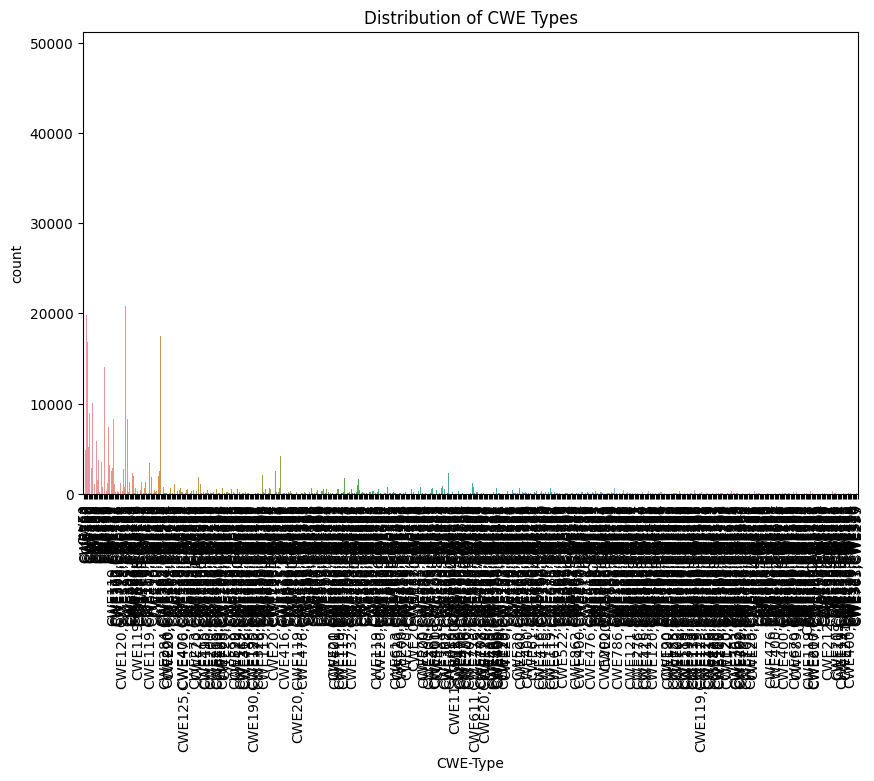

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualizing the data distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='CWE-Type')
plt.xticks(rotation=90)
plt.title('Distribution of CWE Types')
plt.show()

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
dataset = {}
dataset['text'] = list(df_train['code'])
dataset['label'] = list(df_train['label'])
ds = Dataset.from_dict(dataset)
ds = ds.train_test_split(test_size=0.1)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('microsoft/codebert-base-mlm')

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = ds.map(preprocess_function, batched=True)

  0%|          | 0/238 [00:00<?, ?ba/s]

  0%|          | 0/27 [00:00<?, ?ba/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/codebert-base-mlm", num_labels=626, id2label=id2label, label2id=label2id
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base-mlm and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="trained_model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="wandb"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=14873, training_loss=2.9100044602898287, metrics={'train_runtime': 13107.8735, 'train_samples_per_second': 18.154, 'train_steps_per_second': 1.135, 'total_flos': 6.291736194309888e+16, 'train_loss': 2.9100044602898287, 'epoch': 1.0})

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

preds = []
for i in df_test['code'].values:
    with torch.no_grad():
        inputs = tokenizer(i, return_tensors="pt",  truncation=True).to(device)
        logits = model(**inputs).logits
        predicted_class_id = logits.argmax().item()
        preds.append(predicted_class_id)

In [ ]:
y_true = [id2label[i] for i in df_test['label'].values]
y_pred = [id2label[i] for i in preds]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                             precision    recall  f1-score   support

                       CWE0       0.54      0.78      0.64      9814
                    CWE1021       0.00      0.00      0.00        24
                     CWE113       0.00      0.00      0.00         4
  CWE113,CWE200,CWE94,CWE74       0.00      0.00      0.00         3
                     CWE116       0.00      0.00      0.00        44
               CWE116,CWE79       0.00      0.00      0.00         3
                    CWE1187       0.00      0.00      0.00        16
             CWE1187,CWE908       0.00      0.00      0.00         4
                     CWE119       0.48      0.63      0.55      1978
              CWE119,CWE125       0.82      0.30      0.44        76
       CWE119,CWE125,CWE120       0.00      0.00      0.00         4
       CWE119,CWE125,CWE295       0.00      0.00      0.00         9
       CWE119,CWE125,CWE703       0.00      0.00      0.00         6
CWE119,CWE125,CWE703,CWE787      

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


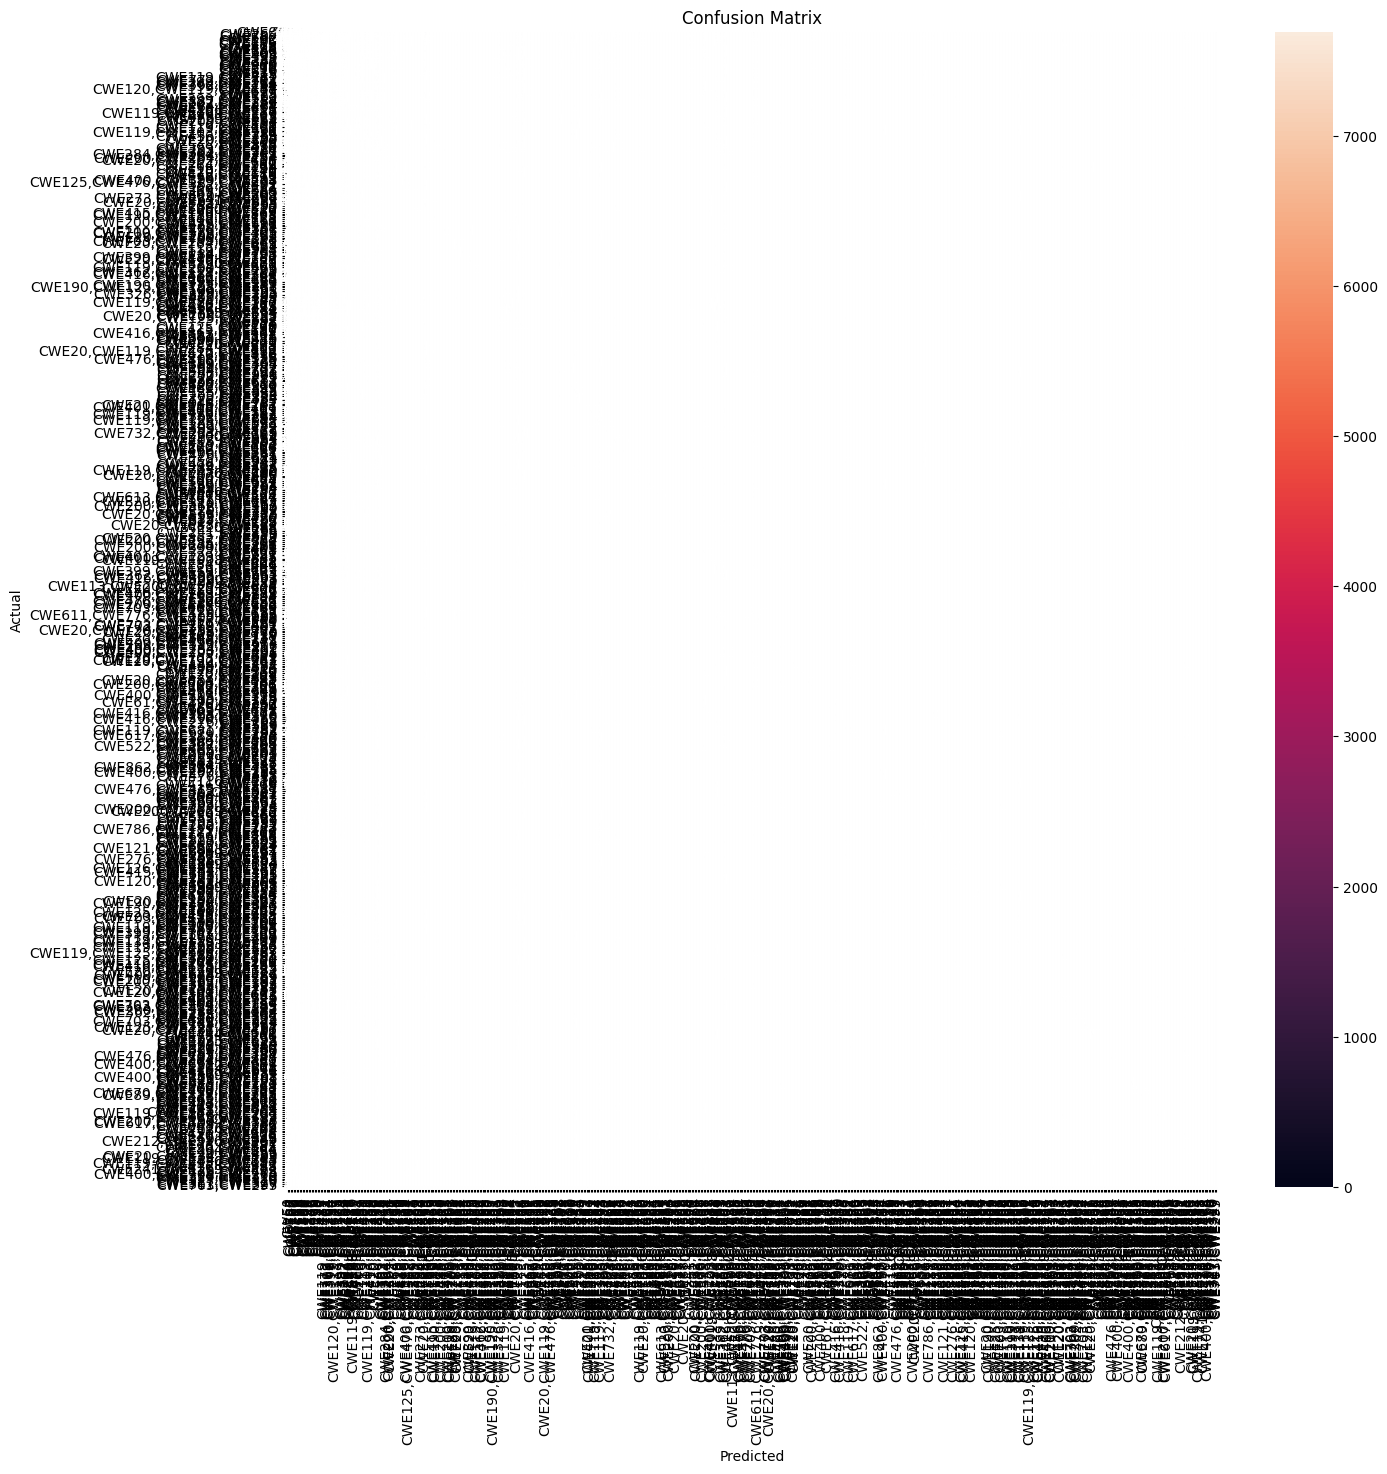

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generating confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred, labels=list(label2id.keys()))
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(conf_matrix, annot=True, fmt="d",
            xticklabels=label2id.keys(),
            yticklabels=label2id.keys(),
            ax=ax)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()